<a href="https://colab.research.google.com/github/henrikass/AI_Bootcamp/blob/master/wineReviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
SETUP = True

In [9]:
if SETUP:
    !pip install -q tensorflow-gpu==2.0.0-rc
    !pip install -q kaggle 
    !pip install -q toai
    !pip install -q -U toai
    !pip install -q -U nb_black
    !pip install -q -U tensorflow-datasets
    !pip install -q -U --no-deps tensorflow-addons~=0.6
    print(__import__("toai").__version__)
    print(__import__("tensorflow").__version__)
    

0.2.5
2.0.0-rc0


In [0]:
import os
from toai.imports import *
from toai.data import DataBundle, DataParams, DataContainer
from toai.metrics import sparse_top_2_categorical_accuracy
import tensorflow as tf
from tensorflow import keras


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
SAVE_DIR = Path('drive/My Drive/ai')

In [0]:
DATA_DIR = Path("data/wine-reviews")
DATA_DIR.mkdir(parents=True, exist_ok=True)

TEMP_DIR = Path("temp/wine-reviews")
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [14]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"henrikass","key":"276ee0ce86dded298da695653159b4c9"}'}

In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [16]:
!kaggle datasets download -d zynicide/wine-reviews -p {str(DATA_DIR)}

 85% 43.0M/50.9M [00:00<00:00, 29.7MB/s]
100% 50.9M/50.9M [00:01<00:00, 52.5MB/s]


In [0]:
shutil.unpack_archive(str(DATA_DIR/'wine-reviews.zip'), extract_dir=str(DATA_DIR)  )

In [0]:
raw_data = pd.read_csv(DATA_DIR/'winemag-data_first150k.csv', low_memory=False)

In [19]:
raw_data.describe(include='all')

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,variety,winery
count,150930.000000,150925,150930,105195,150930.000000,137235.000000,150925,125870,60953,150930,150930
unique,NaN,48,97821,30621,NaN,NaN,455,1236,18,632,14810
top,NaN,US,A little bit funky and unsettled when you pop ...,Reserve,NaN,NaN,California,Napa Valley,Central Coast,Chardonnay,Williams Selyem
freq,NaN,62397,6,2752,NaN,NaN,44508,6209,13057,14482,374
mean,75464.500000,NaN,NaN,NaN,87.888418,33.131482,NaN,NaN,NaN,NaN,NaN
std,43569.882402,NaN,NaN,NaN,3.222392,36.322536,NaN,NaN,NaN,NaN,NaN
min,0.000000,NaN,NaN,NaN,80.000000,4.000000,NaN,NaN,NaN,NaN,NaN
25%,37732.250000,NaN,NaN,NaN,86.000000,16.000000,NaN,NaN,NaN,NaN,NaN
50%,75464.500000,NaN,NaN,NaN,88.000000,24.000000,NaN,NaN,NaN,NaN,NaN
75%,113196.750000,NaN,NaN,NaN,90.000000,40.000000,NaN,NaN,NaN,NaN,NaN


In [20]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150930 entries, 0 to 150929
Data columns (total 11 columns):
Unnamed: 0     150930 non-null int64
country        150925 non-null object
description    150930 non-null object
designation    105195 non-null object
points         150930 non-null int64
price          137235 non-null float64
province       150925 non-null object
region_1       125870 non-null object
region_2       60953 non-null object
variety        150930 non-null object
winery         150930 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 12.7+ MB


In [21]:
raw_data.head(5).T

,0,1,2,3,4
Unnamed: 0,0,1,2,3,4
country,US,Spain,US,US,France
description,This tremendous 100% varietal wine hails from ...,"Ripe aromas of fig, blackberry and cassis are ...",Mac Watson honors the memory of a wine once ma...,"This spent 20 months in 30% new French oak, an...","This is the top wine from La Bégude, named aft..."
designation,Martha's Vineyard,Carodorum Selección Especial Reserva,Special Selected Late Harvest,Reserve,La Brûlade
points,96,96,96,96,95
price,235,110,90,65,66
province,California,Northern Spain,California,Oregon,Provence
region_1,Napa Valley,Toro,Knights Valley,Willamette Valley,Bandol
region_2,Napa,NaN,Sonoma,Willamette Valley,NaN
variety,Cabernet Sauvignon,Tinta de Toro,Sauvignon Blanc,Pinot Noir,Provence red blend


In [22]:
raw_data['description'][123]

"This wine takes time to unravel and reveal itself, rewarding the patient with a wealth of high-toned citrus and elegantly wound, medium-bodied honeyed pear and caramel. Lengthy and complex, it's one to consider aging and allowing to further mellow over time. Drink now through 2021."

In [23]:
type(raw_data['variety'])

pandas.core.series.Series

In [24]:
raw_data['variety'].value_counts()

Chardonnay                  14482
Pinot Noir                  14291
Cabernet Sauvignon          12800
Red Blend                   10062
Bordeaux-style Red Blend     7347
                            ...  
Trousseau Gris                  1
Pinela                          1
Merlot-Petite Verdot            1
Forcallà                        1
Pardina                         1
Name: variety, Length: 632, dtype: int64

In [25]:
raw_data['variety'].value_counts().head(10)

Chardonnay                  14482
Pinot Noir                  14291
Cabernet Sauvignon          12800
Red Blend                   10062
Bordeaux-style Red Blend     7347
Sauvignon Blanc              6320
Syrah                        5825
Riesling                     5524
Merlot                       5070
Zinfandel                    3799
Name: variety, dtype: int64

In [0]:
def drop_rare_values(df, col_name, treshold):
    counts = df[col_name].value_counts(normalize=True)
    return df.loc[df[col_name].isin(counts[counts > treshold].index), :].reset_index(
        drop=True
    )

In [0]:
df = drop_rare_values(raw_data, 'variety', 0.03)

In [45]:
df['variety'].value_counts()

Chardonnay                  14482
Pinot Noir                  14291
Cabernet Sauvignon          12800
Red Blend                   10062
Bordeaux-style Red Blend     7347
Sauvignon Blanc              6320
Syrah                        5825
Riesling                     5524
Merlot                       5070
Name: variety, dtype: int64

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81721 entries, 0 to 81720
Data columns (total 11 columns):
Unnamed: 0     81721 non-null int64
country        81717 non-null object
description    81721 non-null object
designation    55108 non-null object
points         81721 non-null int64
price          75917 non-null float64
province       81717 non-null object
region_1       68377 non-null object
region_2       44099 non-null object
variety        81721 non-null object
winery         81721 non-null object
dtypes: float64(1), int64(2), object(8)
memory usage: 6.9+ MB


In [0]:
for i in df['description'][:3]:
  print(i)
  print('---------------')

This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.
---------------
Mac Watson honors the memory of a wine once made by his mother in this tremendously delicious, balanced and complex botrytised white. Dark gold in color, it layers toasted hazelnut, pear compote and orange peel flavors, reveling in the succulence of its 122 g/L of residual sugar.
---------------
This spent 20 months in 30% new French oak, and incorporates fruit from Ponzi's Aurora, Abetina and Madrona vineyards, among others. Aromatic, dense and toasty, it deftly blends aromas and flavors of toast, cigar box, blackberry, black cherry, coffee and graphite. Tannins are polished to a fine sheen, and frame a finish loaded wi

In [0]:
def make_category_map(labels):
    return {x: i for i, x in enumerate(sorted(set(labels)))}

In [0]:
category_map = make_category_map(df['variety'])

In [47]:
category_map

{'Bordeaux-style Red Blend': 0,
 'Cabernet Sauvignon': 1,
 'Chardonnay': 2,
 'Merlot': 3,
 'Pinot Noir': 4,
 'Red Blend': 5,
 'Riesling': 6,
 'Sauvignon Blanc': 7,
 'Syrah': 8}

In [0]:
from toai.utils import save_file, load_file

In [0]:
def init_category_map(filename, labels):
  try:
    category_map = load_file(filename)
  except:
    category_map = make_category_map(labels)
    save_file(category_map, filename)
  return category_map

In [0]:
category_map = init_category_map(SAVE_DIR/'category_map.pickle', df['variety'])

In [48]:
category_map

{'Bordeaux-style Red Blend': 0,
 'Cabernet Sauvignon': 1,
 'Chardonnay': 2,
 'Merlot': 3,
 'Pinot Noir': 4,
 'Red Blend': 5,
 'Riesling': 6,
 'Sauvignon Blanc': 7,
 'Syrah': 8}

In [0]:
n_categories = len(category_map)

In [36]:
n_categories

9

In [49]:
df['variety'][:10]

0    Cabernet Sauvignon
1       Sauvignon Blanc
2            Pinot Noir
3            Pinot Noir
4            Pinot Noir
5            Pinot Noir
6            Pinot Noir
7            Pinot Noir
8            Chardonnay
9    Cabernet Sauvignon
Name: variety, dtype: object

In [0]:
df['variety'] = df['variety'].map(category_map)

In [51]:
df['variety'].head(10)

0    1
1    7
2    4
3    4
4    4
5    4
6    4
7    4
8    2
9    1
Name: variety, dtype: int64

In [0]:
data_container = DataContainer(
    *DataBundle.split(
        data_bundle=DataBundle.from_dataframe(
            dataframe=df, x_col="description", y_col="variety"
        ),
        fracs=[0.8, 0.1, 0.1],
    )
)

In [53]:
data_container

DataContainer(train=<toai.data.DataBundle.DataBundle object at 0x7f2e60a862b0>, validation=<toai.data.DataBundle.DataBundle object at 0x7f2e60a620f0>, test=<toai.data.DataBundle.DataBundle object at 0x7f2e60a62128>)

In [54]:
df['variety'].value_counts()

2    14482
4    14291
1    12800
5    10062
0     7347
7     6320
8     5825
6     5524
3     5070
Name: variety, dtype: int64

In [55]:
data_container.test.value_counts()

{0: 751, 1: 1287, 2: 1466, 3: 496, 4: 1399, 5: 1007, 6: 543, 7: 621, 8: 601}

In [0]:
class_weights = sk.utils.class_weight.compute_class_weight(
    "balanced", np.unique(data_container.train.y), data_container.train.y
)

In [0]:
class_weights = dict(enumerate(class_weights))

In [59]:
class_weights

{0: 1.2442807658634998,
 1: 0.7099404917035879,
 2: 0.628111639525388,
 3: 1.7834792809013285,
 4: 0.6305652006172839,
 5: 0.905636592832703,
 6: 1.631284776804651,
 7: 1.4407201727709462,
 8: 1.5679065640213925}

In [60]:
len(data_container.train), len(data_container.validation), len(data_container.test)


(65377, 8173, 8171)

In [0]:
def make_dataset(data_bundle):
    return tf.data.Dataset.from_tensor_slices((data_bundle.x, data_bundle.y))

In [62]:
for x, y in make_dataset(data_container.train).take(1):
    print(x)
    print(y)

tf.Tensor(b"This is a Cabernet-dominated Bordeaux blend. It's got muscle and meat, plenty of red and black fruits, and interesting suggestions of fennel. The fruit and herb are nicely balanced and matched, giving the tannins an appealing herbal character that is not too green.", shape=(), dtype=string)
tf.Tensor(1, shape=(), dtype=int64)


In [0]:
data_container.train.dataset, data_container.validation.dataset, data_container.test.dataset = map(
    make_dataset, (data_container.train, data_container.validation, data_container.test)
)

In [64]:
data_container.train.x[0]

"This is a Cabernet-dominated Bordeaux blend. It's got muscle and meat, plenty of red and black fruits, and interesting suggestions of fennel. The fruit and herb are nicely balanced and matched, giving the tannins an appealing herbal character that is not too green."

In [65]:
data_container.train.y[0]

1

In [0]:
def preprocess_batch(x, y, max_length=100):
    x = tf.strings.regex_replace(x, rb"<br\s*/?>", b" ")
    x = tf.strings.regex_replace(x, b"[^A-Za-z]", b" ")
    x = tf.strings.split(x)
    x = x.to_tensor(default_value=b"<pad>")
    paddings = tf.constant([[0, 0], [0, max_length]])
    x = tf.pad(x, paddings, constant_values=b"<pad>")
    x = x[:, :max_length]
    return x, y

In [0]:
BATCH_SIZE = 32

In [68]:
for x, y in (
    data_container.train.dataset.batch(BATCH_SIZE).map(preprocess_batch).take(1)
):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
(32, 100)
(32,)
tf.Tensor(
[b'This' b'is' b'a' b'Cabernet' b'dominated' b'Bordeaux' b'blend' b'It'
 b's' b'got' b'muscle' b'and' b'meat' b'plenty' b'of' b'red' b'and'
 b'black' b'fruits' b'and' b'interesting' b'suggestions' b'of' b'fennel'
 b'The' b'fruit' b'and' b'herb' b'are' b'nicely' b'balanced' b'and'
 b'matched' b'giving' b'the' b'tannins' b'an' b'appealing' b'herbal'
 b'character' b'that' b'is' b'not' b'too' b'green' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>' b'<pad>'
 b'<pad>' b'<pad>' b'<

In [0]:
def make_vocabulary(dataset):
    vocabulary = Counter()
    for x, _ in dataset.batch(BATCH_SIZE).map(preprocess_batch):
        for review in x:
            vocabulary.update(review.numpy().tolist())
    return vocabulary

In [0]:
VOCABULARY_SIZE = 10000

In [0]:
vocabulary = make_vocabulary(data_container.train.dataset)

In [72]:
vocabulary.most_common(20)

[(b'<pad>', 3826402),
 (b'and', 175358),
 (b'the', 90567),
 (b'a', 81218),
 (b'of', 79134),
 (b'with', 61845),
 (b'is', 46363),
 (b'wine', 36923),
 (b'flavors', 35766),
 (b's', 34182),
 (b'in', 33575),
 (b'this', 32340),
 (b'to', 28942),
 (b'it', 27977),
 (b'fruit', 26264),
 (b'The', 22791),
 (b'that', 21270),
 (b'It', 20773),
 (b'but', 20541),
 (b'on', 17988)]

In [73]:
len(vocabulary)

24548

In [0]:
truncated_vocabulary = [word for word, count in vocabulary.most_common(VOCABULARY_SIZE)]

In [75]:
len(truncated_vocabulary)

10000

In [0]:
word_to_id = {word: index for index, word in enumerate(truncated_vocabulary)}

In [77]:
for word in b"This wine is not so good :D".split():
    print(word_to_id.get(word) or VOCABULARY_SIZE)

21
7
6
71
124
47
10000


In [0]:
words = tf.constant(truncated_vocabulary)

In [79]:
words

<tf.Tensor: id=265874, shape=(10000,), dtype=string, numpy=
array([b'<pad>', b'and', b'the', ..., b'Coro', b'luxuriant', b'shadowy'],
      dtype=object)>

In [0]:
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)

In [0]:
n_oov_buckets = VOCABULARY_SIZE // 10

In [82]:
n_oov_buckets

1000

In [0]:
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)

In [0]:
table = tf.lookup.StaticVocabularyTable(vocab_init, n_oov_buckets)

In [85]:
table.lookup(tf.constant([b"This wine is not so good nice and bla bla bla".split()]))

<tf.Tensor: id=265892, shape=(1, 11), dtype=int64, numpy=
array([[   21,     7,     6,    71,   124,    47,   166,     1, 10502,
        10502, 10502]])>

In [0]:
def encode_words(x, y):
    return table.lookup(x), y

In [0]:
train_dataset = (
    data_container.train.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
    .repeat()
    .prefetch(-1)
)

In [0]:
valid_dataset = (
    data_container.validation.dataset.batch(BATCH_SIZE)
    .map(preprocess_batch)
    .map(encode_words)
)

In [89]:
for x, y in train_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 100)
(32,)
tf.Tensor(
[  21    6    3   44  617  247   52   17    9  962 1656    1  338  197
    4   41    1   29   63    1  372 1274    4 1480   15   14    1  157
   28  304   94    1 2008  356    2   22   45  455  128  103   16    6
   71  176   65    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(100,), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)


In [90]:
for x, y in valid_dataset.take(1):
    print(x.shape)
    print(y.shape)
    print(x[0])
    print(y[0])

(32, 100)
(32,)
tf.Tensor(
[  284  1192     4  2910  8726   200    59    19     2    56     4    11
   290    27     2 10249   681     5    35     4  1881  1112  5117     1
  1447   210    15    33     6   772    99    10   376   203     8     4
  1881  6233  1298  1334     1     3   916   103     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0], shape=(100,), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)


In [0]:
train_data_steps = len(data_container.train) // BATCH_SIZE

In [0]:
valid_data_steps = len(data_container.validation) // BATCH_SIZE

In [0]:
def make_sequential_lstm_model(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:

model1 = make_sequential_lstm_model(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.5,
)

In [0]:
model1.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [100]:
history = model1.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=valid_dataset,
    validation_steps=valid_data_steps,
    epochs=2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(str(SAVE_DIR)+'/model1_nofeatures.h5', save_best_only=True)
    ],
    class_weight=class_weights,
)

Train for 2043 steps, validate for 255 steps
Epoch 1/2
2043/2043 [==============================] - 692s 339ms/step - loss: 1.1398 - sparse_categorical_accuracy: 0.6049 - sparse_top_2_categorical_accuracy: 0.7615 - val_loss: 0.6766 - val_sparse_categorical_accuracy: 0.7659 - val_sparse_top_2_categorical_accuracy: 0.8822
Epoch 2/2
2043/2043 [==============================] - 666s 326ms/step - loss: 0.6149 - sparse_categorical_accuracy: 0.7932 - sparse_top_2_categorical_accuracy: 0.8930 - val_loss: 0.5669 - val_sparse_categorical_accuracy: 0.8034 - val_sparse_top_2_categorical_accuracy: 0.9037


In [166]:
history_1 = model1.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=valid_dataset,
    validation_steps=valid_data_steps,
    epochs=2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(str(SAVE_DIR)+'/model1_nofeatures.h5', save_best_only=True)
    ],
    class_weight=class_weights,
)

Train for 2043 steps, validate for 255 steps
Epoch 1/2
2043/2043 [==============================] - 664s 325ms/step - loss: 0.4869 - sparse_categorical_accuracy: 0.8374 - sparse_top_2_categorical_accuracy: 0.9183 - val_loss: 0.5249 - val_sparse_categorical_accuracy: 0.8214 - val_sparse_top_2_categorical_accuracy: 0.9112
Epoch 2/2
2043/2043 [==============================] - 656s 321ms/step - loss: 0.4131 - sparse_categorical_accuracy: 0.8645 - sparse_top_2_categorical_accuracy: 0.9354 - val_loss: 0.5036 - val_sparse_categorical_accuracy: 0.8290 - val_sparse_top_2_categorical_accuracy: 0.9150


In [0]:
model1.load_weights(str(SAVE_DIR)+"/model1_nofeatures.h5")

In [102]:
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          704000    
_________________________________________________________________
bidirectional (Bidirectional (None, None, 128)         66048     
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 128)         98816     
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 9)                 1161      
Total params: 870,025
Trainable params: 870,025
Non-trainable params: 0
__________________________________________________

In [167]:
model1.evaluate(valid_dataset, steps=valid_data_steps)

255/255 [==============================] - 19s 74ms/step - loss: 0.5036 - sparse_categorical_accuracy: 0.8290 - sparse_top_2_categorical_accuracy: 0.9150


[0.5036485834448945, 0.8290441, 0.91495097]

In [168]:
print(classification_report(data_container.validation.y, model1.predict(valid_dataset).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.79      0.81      0.80       758
           1       0.72      0.86      0.78      1281
           2       0.90      0.92      0.91      1451
           3       0.63      0.61      0.62       501
           4       0.86      0.89      0.88      1372
           5       0.88      0.77      0.82      1034
           6       0.88      0.91      0.90       528
           7       0.90      0.79      0.84       657
           8       0.91      0.68      0.78       591

    accuracy                           0.83      8173
   macro avg       0.83      0.80      0.81      8173
weighted avg       0.83      0.83      0.83      8173



In [0]:

def make_cnn_model(
    n_categories, embedding_size, conv_size, kernel_size, dropout, stride=2
):
    input_layer = keras.layers.Input(shape=[None])
    mask = keras.layers.Lambda(lambda inputs: keras.backend.not_equal(inputs, 0))(
        input_layer
    )
    embedding_layer = keras.layers.Embedding(
        VOCABULARY_SIZE + n_oov_buckets, embedding_size
    )(input_layer)
    cnn1_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(embedding_layer)
    cnn1_dropout = keras.layers.Dropout(dropout)(cnn1_layer)
    cnn2_layer = keras.layers.Conv1D(
        conv_size,
        kernel_size=kernel_size,
        strides=stride,
        activation=keras.activations.relu,
        kernel_initializer=keras.initializers.he_uniform(),
    )(cnn1_dropout)
    cnn2_dropout = keras.layers.Dropout(dropout)(cnn2_layer)
    max_pool_layer = keras.layers.GlobalMaxPool1D()(cnn2_dropout)
    dropout_layer = keras.layers.Dropout(dropout)(max_pool_layer)
    output_layer = keras.layers.Dense(
        n_categories, activation=keras.activations.softmax
    )(dropout_layer)
    return keras.Model(inputs=input_layer, outputs=output_layer)

In [0]:
model2 = make_cnn_model(
    n_categories=n_categories,
    embedding_size=64,
    conv_size=64,
    kernel_size=3,
    dropout=0.5,
)


In [118]:
model2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_1 (Embedding)      (None, None, 64)          704000    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
dropout_7 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, None, 64)          12352     
_________________________________________________________________
dropout_8 (Dropout)          (None, None, 64)          0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 64)                0     

In [0]:
model2.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [121]:
history2 = model2.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=valid_dataset,
    validation_steps=valid_data_steps,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(str(SAVE_DIR)+'/model2.h5', save_best_only=True)
    ],
    class_weight=class_weights,
)

Train for 2043 steps, validate for 255 steps
Epoch 1/10
2043/2043 [==============================] - 44s 21ms/step - loss: 0.9554 - sparse_categorical_accuracy: 0.6437 - sparse_top_2_categorical_accuracy: 0.8066 - val_loss: 0.8430 - val_sparse_categorical_accuracy: 0.7397 - val_sparse_top_2_categorical_accuracy: 0.8714
Epoch 2/10
2043/2043 [==============================] - 44s 21ms/step - loss: 0.8328 - sparse_categorical_accuracy: 0.7042 - sparse_top_2_categorical_accuracy: 0.8480 - val_loss: 0.7369 - val_sparse_categorical_accuracy: 0.7737 - val_sparse_top_2_categorical_accuracy: 0.8859
Epoch 3/10
2043/2043 [==============================] - 44s 22ms/step - loss: 0.7424 - sparse_categorical_accuracy: 0.7432 - sparse_top_2_categorical_accuracy: 0.8715 - val_loss: 0.6722 - val_sparse_categorical_accuracy: 0.7983 - val_sparse_top_2_categorical_accuracy: 0.8972
Epoch 4/10
2043/2043 [==============================] - 47s 23ms/step - loss: 0.6769 - sparse_categorical_accuracy: 0.7701 - sp

In [171]:
history2_1 = model2.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=valid_dataset,
    validation_steps=valid_data_steps,
    epochs=10,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(str(SAVE_DIR)+'/model2.h5', save_best_only=True)
    ],
    class_weight=class_weights,
)

Train for 2043 steps, validate for 255 steps
Epoch 1/10
2043/2043 [==============================] - 40s 19ms/step - loss: 0.4633 - sparse_categorical_accuracy: 0.8488 - sparse_top_2_categorical_accuracy: 0.9355 - val_loss: 0.5364 - val_sparse_categorical_accuracy: 0.8348 - val_sparse_top_2_categorical_accuracy: 0.9142
Epoch 2/10
2043/2043 [==============================] - 40s 19ms/step - loss: 0.4496 - sparse_categorical_accuracy: 0.8531 - sparse_top_2_categorical_accuracy: 0.9389 - val_loss: 0.5307 - val_sparse_categorical_accuracy: 0.8374 - val_sparse_top_2_categorical_accuracy: 0.9153
Epoch 3/10
2043/2043 [==============================] - 39s 19ms/step - loss: 0.4290 - sparse_categorical_accuracy: 0.8595 - sparse_top_2_categorical_accuracy: 0.9428 - val_loss: 0.5273 - val_sparse_categorical_accuracy: 0.8390 - val_sparse_top_2_categorical_accuracy: 0.9141
Epoch 4/10
2043/2043 [==============================] - 39s 19ms/step - loss: 0.4182 - sparse_categorical_accuracy: 0.8650 - sp

In [172]:
model2.evaluate(valid_dataset, steps=valid_data_steps)

255/255 [==============================] - 1s 6ms/step - loss: 0.5222 - sparse_categorical_accuracy: 0.8439 - sparse_top_2_categorical_accuracy: 0.9170


[0.5222428195616778, 0.84387255, 0.9170343]

In [173]:
print(classification_report(data_container.validation.y, model2.predict(valid_dataset).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.84      0.78      0.81       758
           1       0.80      0.84      0.82      1281
           2       0.91      0.92      0.91      1451
           3       0.70      0.67      0.68       501
           4       0.83      0.90      0.87      1372
           5       0.86      0.82      0.84      1034
           6       0.88      0.88      0.88       528
           7       0.89      0.84      0.86       657
           8       0.83      0.77      0.80       591

    accuracy                           0.84      8173
   macro avg       0.84      0.83      0.83      8173
weighted avg       0.84      0.84      0.84      8173



In [0]:
def make_hybrid_model(
    n_categories, embedding_size, lstm_size, lstm_dropout, dropout
):
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            keras.layers.Bidirectional(
                keras.layers.LSTM(
                    lstm_size, dropout=lstm_dropout, return_sequences=True
                )
            ),
            keras.layers.Conv1D(
                256,
                kernel_size = 5,
                strides = 2,
                padding = 'same',
                activation = keras.activations.relu,
                kernel_initializer = keras.initializers.he_uniform()
            ),
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model3 = make_hybrid_model(
    n_categories=n_categories,
    embedding_size=64,
    lstm_size=64,
    lstm_dropout=0.2,
    dropout=0.5,
)

In [0]:
model3.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [137]:
model3.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 64)          704000    
_________________________________________________________________
bidirectional_2 (Bidirection (None, None, 128)         66048     
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 256)         164096    
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 256)               0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 9)                 2313      
Total params: 936,457
Trainable params: 936,457
Non-trainable params: 0
________________________________________________

In [127]:
history3 = model3.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=valid_dataset,
    validation_steps=valid_data_steps,
    epochs=2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(str(SAVE_DIR)+'/model3.h5', save_best_only=True)
    ],
    class_weight=class_weights,
)

Train for 2043 steps, validate for 255 steps
Epoch 1/2
2043/2043 [==============================] - 441s 216ms/step - loss: 0.9805 - sparse_categorical_accuracy: 0.6507 - sparse_top_2_categorical_accuracy: 0.7872 - val_loss: 0.5820 - val_sparse_categorical_accuracy: 0.8048 - val_sparse_top_2_categorical_accuracy: 0.9000
Epoch 2/2
2043/2043 [==============================] - 421s 206ms/step - loss: 0.5313 - sparse_categorical_accuracy: 0.8209 - sparse_top_2_categorical_accuracy: 0.9120 - val_loss: 0.5051 - val_sparse_categorical_accuracy: 0.8279 - val_sparse_top_2_categorical_accuracy: 0.9183


In [176]:
history3 = model3.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=valid_dataset,
    validation_steps=valid_data_steps,
    epochs=2,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(str(SAVE_DIR)+'/model3.h5', save_best_only=True)
    ],
    class_weight=class_weights,
)

Train for 2043 steps, validate for 255 steps
Epoch 1/2
2043/2043 [==============================] - 443s 217ms/step - loss: 0.4244 - sparse_categorical_accuracy: 0.8581 - sparse_top_2_categorical_accuracy: 0.9352 - val_loss: 0.4839 - val_sparse_categorical_accuracy: 0.8407 - val_sparse_top_2_categorical_accuracy: 0.9244
Epoch 2/2
2043/2043 [==============================] - 446s 218ms/step - loss: 0.3543 - sparse_categorical_accuracy: 0.8832 - sparse_top_2_categorical_accuracy: 0.9499 - val_loss: 0.4789 - val_sparse_categorical_accuracy: 0.8449 - val_sparse_top_2_categorical_accuracy: 0.9261


In [177]:
model3.evaluate(valid_dataset, steps=valid_data_steps)

255/255 [==============================] - 11s 44ms/step - loss: 0.4789 - sparse_categorical_accuracy: 0.8449 - sparse_top_2_categorical_accuracy: 0.9261


[0.47885694474566215, 0.8448529, 0.92610294]

In [178]:
print(classification_report(data_container.validation.y, model3.predict(valid_dataset).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.83      0.83      0.83       758
           1       0.80      0.82      0.81      1281
           2       0.90      0.94      0.92      1451
           3       0.67      0.69      0.68       501
           4       0.88      0.87      0.88      1372
           5       0.87      0.80      0.84      1034
           6       0.91      0.90      0.91       528
           7       0.91      0.83      0.87       657
           8       0.74      0.80      0.77       591

    accuracy                           0.84      8173
   macro avg       0.83      0.83      0.83      8173
weighted avg       0.85      0.84      0.85      8173



In [0]:
def make_wavenet_model(n_categories, embedding_size, conv_size, dropout):
    model_layers = []
    for rate in (1, 2, 4, 8, 16) * 3:
        model_layers.append(
            keras.layers.Conv1D(
                filters=conv_size,
                kernel_size=2,
                padding="causal",
                dilation_rate=rate,
                activation=keras.activations.relu,
                kernel_initializer=keras.initializers.he_uniform(),
            )
        )
        model_layers.append(keras.layers.Dropout(dropout))
    return keras.models.Sequential(
        [
            keras.layers.Embedding(
                VOCABULARY_SIZE + n_oov_buckets,
                embedding_size,
                mask_zero=True,
                input_shape=[None],
            ),
            *model_layers,
            keras.layers.GlobalMaxPool1D(),
            keras.layers.Dropout(dropout),
            keras.layers.Dense(n_categories, activation=keras.activations.softmax),
        ]
    )

In [0]:
model4 = make_wavenet_model(
    n_categories=n_categories, embedding_size=64, conv_size=64, dropout=0.5
)

In [0]:
model4.compile(
    loss=keras.losses.sparse_categorical_crossentropy,
    optimizer=keras.optimizers.Adam(lr=3e-4),
    metrics=[
        keras.metrics.sparse_categorical_accuracy,
        sparse_top_2_categorical_accuracy,
    ],
)

In [136]:
model4.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 64)          704000    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 64)          8256      
_________________________________________________________________
dropout_11 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
dropout_12 (Dropout)         (None, None, 64)          0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, None, 64)          8256      
_________________________________________________________________
dropout_13 (Dropout)         (None, None, 64)         

In [133]:
history4 = model4.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=valid_dataset,
    validation_steps=valid_data_steps,
    epochs=3,
    callbacks=[
        keras.callbacks.ReduceLROnPlateau(patience=1, factor=0.3),
        keras.callbacks.EarlyStopping(patience=3, restore_best_weights=True),
        keras.callbacks.ModelCheckpoint(str(SAVE_DIR)+'/model4.h5', save_best_only=True)
    ],
    class_weight=class_weights,
)

Train for 2043 steps, validate for 255 steps
Epoch 1/3
2043/2043 [==============================] - 372s 182ms/step - loss: 2.4398 - sparse_categorical_accuracy: 0.1717 - sparse_top_2_categorical_accuracy: 0.3367 - val_loss: 2.1414 - val_sparse_categorical_accuracy: 0.1776 - val_sparse_top_2_categorical_accuracy: 0.3453
Epoch 2/3
2043/2043 [==============================] - 379s 186ms/step - loss: 2.0183 - sparse_categorical_accuracy: 0.2528 - sparse_top_2_categorical_accuracy: 0.4052 - val_loss: 2.1504 - val_sparse_categorical_accuracy: 0.1776 - val_sparse_top_2_categorical_accuracy: 0.3343
Epoch 3/3
2043/2043 [==============================] - 383s 187ms/step - loss: 1.8981 - sparse_categorical_accuracy: 0.3373 - sparse_top_2_categorical_accuracy: 0.4851 - val_loss: 2.1620 - val_sparse_categorical_accuracy: 0.1776 - val_sparse_top_2_categorical_accuracy: 0.3343


In [134]:
model4.evaluate(valid_dataset, steps=valid_data_steps)

255/255 [==============================] - 12s 49ms/step - loss: 2.1620 - sparse_categorical_accuracy: 0.1776 - sparse_top_2_categorical_accuracy: 0.3343


[2.162030045191447, 0.17757353, 0.33431372]

In [135]:
print(classification_report(data_container.validation.y, model4.predict(valid_dataset).argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       758
           1       0.00      0.00      0.00      1281
           2       0.18      1.00      0.30      1451
           3       0.00      0.00      0.00       501
           4       0.00      0.00      0.00      1372
           5       0.00      0.00      0.00      1034
           6       0.00      0.00      0.00       528
           7       0.00      0.00      0.00       657
           8       0.00      0.00      0.00       591

    accuracy                           0.18      8173
   macro avg       0.02      0.11      0.03      8173
weighted avg       0.03      0.18      0.05      8173



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [169]:
loss1 = model1.evaluate(valid_dataset, steps=valid_data_steps)

255/255 [==============================] - 19s 73ms/step - loss: 0.5036 - sparse_categorical_accuracy: 0.8290 - sparse_top_2_categorical_accuracy: 0.9150


In [179]:
loss2 = model2.evaluate(valid_dataset, steps=valid_data_steps)
loss3 = model3.evaluate(valid_dataset, steps=valid_data_steps)
loss4 = model4.evaluate(valid_dataset, steps=valid_data_steps)

255/255 [==============================] - 12s 47ms/step - loss: 2.1620 - sparse_categorical_accuracy: 0.1776 - sparse_top_2_categorical_accuracy: 0.3343


In [0]:
%matplotlib inline

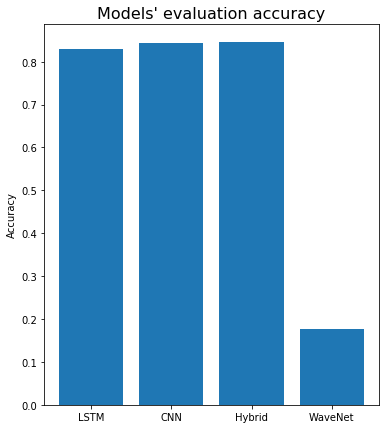

In [180]:
plt.figure(figsize=(6,7))
y_pos = np.arange(4)
models = ['LSTM', 'CNN', 'Hybrid', 'WaveNet']
h = [loss1[1], loss2[1], loss3[1], loss4[1]]
plt.bar(y_pos, h)
plt.xticks(y_pos, models)
plt.ylabel('Accuracy')
plt.title("Models' evaluation accuracy", fontsize=16)
plt.show()


In [0]:
# LSTM [0.5036485834448945, 0.8290441, 0.91495097]
# CNN [0.5222428195616778, 0.84387255, 0.9170343]
# Hybrid [0.47885694474566215, 0.8448529, 0.92610294]
# WaveNet [2.162030045191447, 0.17757353, 0.33431372]
